### Abstract

#### This notebook pertains to non-deterministic clustering for novelty detection in unstructured log data.

### Non-Deterministic Clustering (Generalized Expectation Maximization: Gaussian Mixture Models¶)

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset. In the simplest case, GMMs can be used for finding clusters in the same manner as k-means. But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the predict_proba method. This returns a matrix of size [n_samples, n_clusters] which measures the probability that any point belongs to the given cluster. We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction. The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model. 



#### Expectation Maximization Algorithm
Choose starting guesses for the location and shape

Repeat until converged:

1. E-step: for each point, find weights encoding the probability of membership in each cluster
2. M-step: for each cluster, update its location, normalization, and shape based on all data points, making use of the weights

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
from sklearn.cluster import KMeans, MiniBatchKMeans
import logging
from optparse import OptionParser
import sys
from time import time
import numpy as np
from sklearn.mixture import GaussianMixture

#### News Data

In [2]:
# #############################################################################
# Load some categories from the training set
categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]
# Uncomment the following to do the analysis on all the categories
# categories = None

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']


In [3]:
dataset = fetch_20newsgroups(
    subset="all", categories=categories, shuffle=True, random_state=42
)

print("%d documents" % len(dataset.data))
print("%d categories" % len(dataset.target_names))
print()

labels = dataset.target
true_k = np.unique(labels).shape[0]

3387 documents
4 categories



In [4]:
vectorizer = TfidfVectorizer(
        max_df=0.5,
        max_features=5,
        min_df=2,
        stop_words="english",
    )

In [5]:
X = vectorizer.fit_transform(dataset.data)
print("n_samples: %d, n_features: %d" % X.shape)
print()

n_samples: 3387, n_features: 5



In [6]:
print("Performing dimensionality reduction using LSA")
t0 = time()
# Vectorizer results are normalized, which makes KMeans behave as
# spherical k-means for better results. Since LSA/SVD results are
# not normalized, we have to redo the normalization.
svd = TruncatedSVD()
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

X = lsa.fit_transform(X)

print("done in %fs" % (time() - t0))

explained_variance = svd.explained_variance_ratio_.sum()
print(
    "Explained variance of the SVD step: {}%".format(int(explained_variance * 100))
)

print()

Performing dimensionality reduction using LSA
done in 0.011931s
Explained variance of the SVD step: 43%



In [9]:
gm.means_

array([[ 0.98371332, -0.02074082],
       [ 0.65360429,  0.73500612],
       [ 0.        ,  0.        ],
       [ 0.84166877, -0.51921586]])

In [10]:
gm.predict_proba([[1, 1]])

array([[1.00000000e+00, 7.49838739e-69, 0.00000000e+00, 0.00000000e+00]])

In [11]:
gm.get_params(deep=True)

{'covariance_type': 'full',
 'init_params': 'kmeans',
 'max_iter': 100,
 'means_init': None,
 'n_components': 4,
 'n_init': 1,
 'precisions_init': None,
 'random_state': 0,
 'reg_covar': 1e-06,
 'tol': 0.001,
 'verbose': 0,
 'verbose_interval': 10,
 'warm_start': False,
 'weights_init': None}

In [12]:
gm.score(X)

3.5639151422405253

### Numerical Data

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import sklearn
from sklearn.mixture import GaussianMixture as GMM

In [54]:
# Generate some data
from sklearn.datasets import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

In [36]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

In [37]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import sklearn
from sklearn.mixture import GaussianMixture as GMM

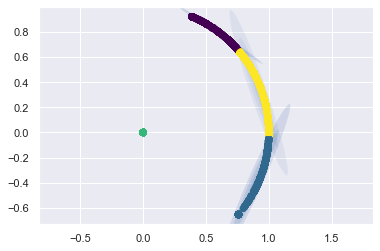

In [43]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X)

In [56]:
print("Clustering sparse data with %s" % gm)
t0 = time()
gmm.fit(X)
print("done in %0.3fs" % (time() - t0))
print()
print("akaike information criterion: %0.3f" % gm.aic(X))
print("bayesian information criterion: %0.3f" % gm.bic(X))
print()
terms = vectorizer.get_feature_names()
print(f'the key terms in the corpus: {terms}')
print()
print('the location of the centroid:') 
print(gm.means_)
print()
print('the prediction for a new point:') 
print(gm.predict_proba([[1, 1]]))
print()
print('the model parameters:') 
print(gm.get_params(deep=True))
print()
print("model performance score: %0.3f" % gm.score(X))

Clustering sparse data with GaussianMixture(n_components=4, random_state=0)
done in 0.080s

akaike information criterion: -24095.961
bayesian information criterion: -23955.024

the key terms in the corpus: ['article', 'com', 'don', 'god', 'space']

the location of the centroid:
[[ 0.98371332 -0.02074082]
 [ 0.65360429  0.73500612]
 [ 0.          0.        ]
 [ 0.84166877 -0.51921586]]

the prediction for a new point:
[[1.00000000e+00 7.49838739e-69 0.00000000e+00 0.00000000e+00]]

the model parameters:
{'covariance_type': 'full', 'init_params': 'kmeans', 'max_iter': 100, 'means_init': None, 'n_components': 4, 'n_init': 1, 'precisions_init': None, 'random_state': 0, 'reg_covar': 1e-06, 'tol': 0.001, 'verbose': 0, 'verbose_interval': 10, 'warm_start': False, 'weights_init': None}

model performance score: 3.564


### Schematic Data

In [54]:
# Generate some data
from sklearn.datasets import make_blobs
X_1, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X_1 = X_1[:, ::-1] # flip axes for better plotting

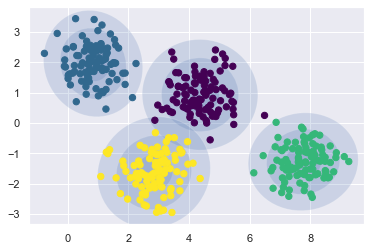

In [55]:
plot_gmm(gmm, X_1)